# Image Enhancement in Frequency Domain #

Overview:  
A. Domain Frekuensi  
B. Transformasi Fourier (FT)  
C. Filtering 
  1. Low-Pass Filter (LPF)
  1. High-Pass Filter (HPF)
   
  
### A. Domain Frekuensi  ###
  
Pada beberapa materi sebelumnya, kita mengenal domain citra digital sebagai spasial. Namun, ada domain lain yang dinamakan sebagai domain frekuensi. Jika pada domain spasial, kita melihat koordinat citra digital sebagai ukuran piksel maka pada domain frekuensi, koordinat berubah menjadi hubungan antara frekuensi dengan waktu (time). Istilah frekuensi pada citra disebut sebagai **laju perubahan piksel**.  
  
Sebenarnya, ada banyak cara untuk meningkatkan kualitas citra. Teknik seperti transformasi gamma, log, dan kernel spasial menggunakan domain spasial. Namun, ada beberapa kondisi di mana domain frekuensi bisa mengenali informasi yang mana pada domain spasial tidak bisa.  
  
### B. Transformasi Fourier ###  
  
Ada sebuah pendekatan untuk mengubah domain citra dari spasial ke frekuensi. Pendekatan ini menggunakan teknik yang disebut sebagai **transformasi Fourier (FT)**.  FT ditemukan oleh Joseph Fourier pada abad ke-18.  
  
**Apa yang dilakukan FT terhadap citra?**   
Sebagai ilustrasi, ibaratkan citra sebagai **sambal pecel**. Jika sambal pecel ini diolah dengan FT, maka luaran dari FT ini adalah komposisi dari sambel pecel. 

**Cara kerja FT ini bagaimana?**  
Ya sederhana saja, masukkan **sambel pecel** ke dalam FT, maka kita akan mendapatkan resep dari pecel.  
  
**Kenapa sambel harus di FT?**  
Idenya begini..  
Misalnya, ketika kalian melihat permukaan sambel pecel, kalian menemukan beberapa noda hitam atau coklat tua yang tersebar hampir ke seluruh permukaan. Kalian penasaran, apa yang menyebabkan ini semua? Dengan teknik FT, kalian bisa mendapatkan bahan-bahan dasar dari pecel. Kemudian, kalian mengamati lagi tiap-tiap bahan kemudian di filter bahan tersebut sehingga bersih.  
  
  
![Ilustrasi FT](images/ilustrasi_fourier.jpg)  
  

### C. Filtering ###  

Proses pada FT tidak terlepas dari filtering. Ada beberapa teknik filtering, yang umum dipakai diantaranya adalah Low-pass dan High-pass filtering.  
#### 1. Low-pass Filtering (LPF) ####

LPF adalah memotong semua frekuensi yang berada di atas ambang batas (threshold) atau cut-off. Setiap frekuensi yang melebihi cut-off, akan bernilai nol. Sehingga, hasil dari LPF ini adalah frekuensi-frekuensi yang rendah saja.

#### 2. High-pass Filtering (HPF) ####
  
**Apa yang dilakukan setelah membersihkan bahan-bahan tadi?**  
Bagaimana cara me-reproduksi pecel yang sudah disaring tiap bahannya? Ya sederhana saja, kita selep / blender lagi. Proses ini dinamakan sebagai *reverse engineering* atau *inverse*. Dalam konteks FT, dinamakan sebagai *Inverse Fourier Transform* (IFT).  
  
 

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt## make a test image
import math

In [5]:


def plotTwoImages(img1, img2):
    plt.figure(figsize=(15, 15))
    plt.subplot(1,2,1)
    plt.title('Image asli')
    plt.imshow(img1,  cmap='gray', vmin=0, vmax=255) # original image
    plt.xlabel("x [pixels]")
    plt.ylabel("y [pixles]")
    plt.subplot(1,2,2)
    plt.title('Image Output')
    plt.imshow(img2,  cmap='gray', vmin=0, vmax=255) # fourier transform
    plt.xlabel("x [pixels]")
    plt.ylabel("y [pixles]")
    plt.tight_layout()
    plt.show() # just display the figure, not saved

In [6]:
def get_fft_image(img_input):
    
    f = cv2.dft(np.float32(img), flags=cv2.DFT_COMPLEX_OUTPUT)
    f_shift = np.fft.fftshift(f)
    f_complex = f_shift[:,:,0] + 1j*f_shift[:,:,1]
    f_abs = np.abs(f_complex) + 1 # lie between 1 and 1e6
    f_bounded = 20 * np.log(f_abs)
    f_img = 255 * f_bounded / np.max(f_bounded)
    f_img = f_img.astype(np.uint8)## Make figures
    return f_img


In [7]:
def low_pass_filter(img_input, radius):
    fft = cv2.dft(np.float32(img_input), flags=cv2.DFT_COMPLEX_OUTPUT)
    
    dshift = np.fft.fftshift(fft)
    
    rows, cols = img_input.shape[:2]
    mid_row, mid_col = int(rows / 2), int(cols / 2)
    
    
    mask = np.zeros((rows, cols, 2), np.float32)
    mask[mid_row - radius:mid_row + radius, mid_col - radius:mid_col + radius] = 1
    
    fft_filtering = dshift * mask
    
    ishift = np.fft.ifftshift(fft_filtering)
    img_output = cv2.idft(ishift)
    img_output = cv2.magnitude(img_output[:,:,0], img_output[:,:,1])
    
    cv2.normalize(img_output, img_output, 0, 1, cv2.NORM_MINMAX)
    return img_output



In [8]:
def high_pass_filter(img_input, radius, n):
    fft = cv2.dft(np.float32(img_input), flags=cv2.DFT_COMPLEX_OUTPUT)
    
    dshift = np.fft.fftshift(fft)
    
    rows, cols = img_input.shape[:2]
    mid_row, mid_col = int(rows / 2), int(cols / 2)
    
    
    mask = np.zeros((rows, cols, 2), np.float32)
    
    for i in range(0, rows):
        for j in range(0, cols):
            d = math.sqrt(pow(i - mid_row, 2) + pow(j - mid_col, 2))
            
            try:
                mask[i, j, 0] = mask[i, j, 1] = 1 / (1 + pow(radius / d, 2*n))
            except ZeroDivisionError:
                mask[i, j, 0] = mask[i, j, 1] = 0
                
                
    
    fft_filtering = dshift * mask
    
    ishift = np.fft.ifftshift(fft_filtering)
    img_output = cv2.idft(ishift)
    img_output = cv2.magnitude(img_output[:,:,0], img_output[:,:,1])
    
    cv2.normalize(img_output, img_output, 0, 1, cv2.NORM_MINMAX)
    return img_output

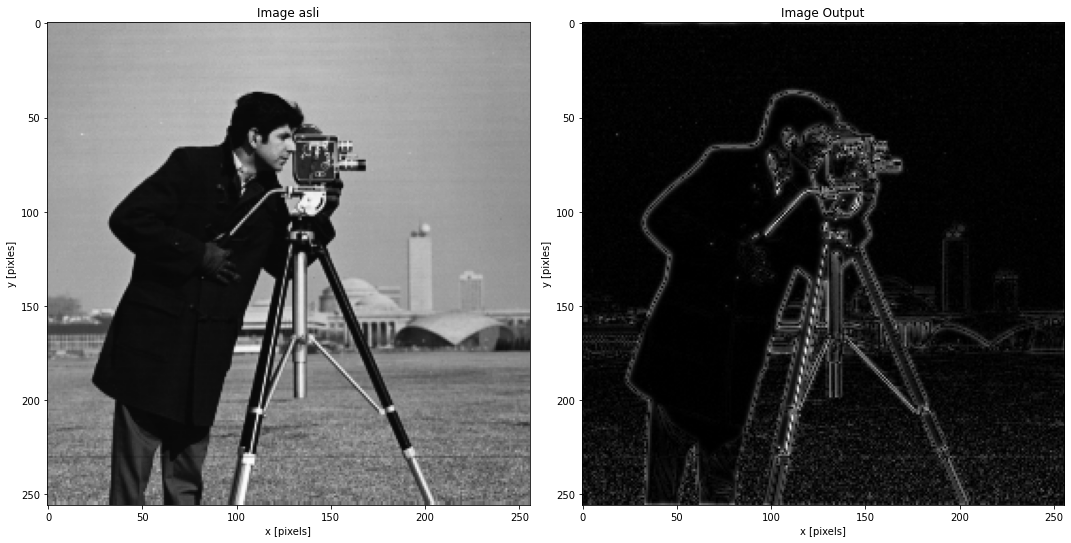

In [12]:
img = cv2.imread('dataset/cameraman.png',0)
img_output = high_pass_filter(img, 50,1)
# img_output = low_pass_filter(img,30)
# img_output = get_fft_image(img)



plotTwoImages(img, img_output * 255)

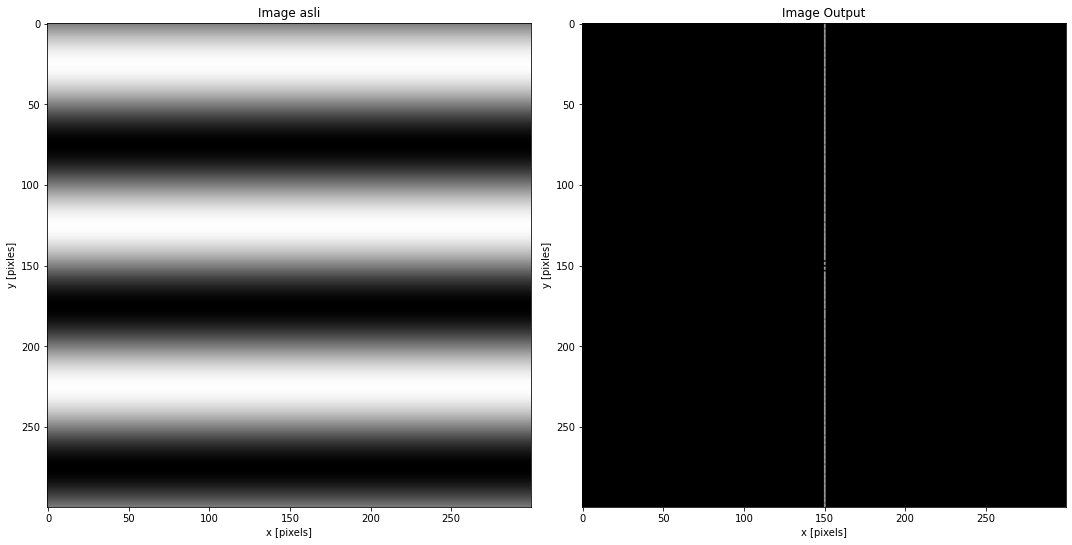

In [7]:
img = np.ones((300, 300))*0 # plane black

for i in range(img.shape[0]):
    val = 127*(np.sin(2*np.pi*i*3.0/img.shape[0])+1)
    img[i,:] = val # add parttern alogn the y-axis
    
img = np.uint8(img)

img_fft = get_fft_image(img)

plotTwoImages(img, img_fft* 255)